In [202]:
# Greg Maurer - August 2015

library(ggplot2)
library(plyr)
library(reshape2)

theme_set(theme_bw())

setwd('~/current/NMEG_miscellany/')

proc_path <- 'processed_data/'
outpath <- 'figures/'

source('~/current/NMEG_utils/r_functions/printfigs.r')
source('~/current/NMEG_utils/r_functions/load_nmeg.r')
source('~/current/NMEG_utils/r_functions/transform_nmeg.r')
#source('load_datasets.r')

# Get flux datasets
seg <- get_daily_file('Seg', 'aflx', make_new=FALSE)
ses <- get_daily_file('Ses', 'aflx')
wjs <- get_daily_file('Wjs', 'aflx')
mpj <- get_daily_file('Mpj', 'aflx')
vcp <- get_daily_file('Vcp', 'aflx')
vcm <- get_daily_file('Vcm', 'aflx')
# Put together one-variable dataframes with season columns and such
sitelist <- list(seg, ses, wjs, mpj, vcp, vcm)
sitenames <- c('Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm')
FC_daily <- get_var_allsites(sitelist, 'FC_F_g_int', sitenames, startyear=2007, endyear=2014)
GPP_daily <- get_var_allsites(sitelist, 'GPP_g_int', sitenames, startyear=2007, endyear=2014)
RE_daily <- get_var_allsites(sitelist, 'RECO_g_int', sitenames, startyear=2007, endyear=2014)
ET_daily <- get_var_allsites(sitelist, 'ET_F_mm_daytime', sitenames, startyear=2007, endyear=2014)

head(FC_daily)

,date,Seg,Ses,Wjs,Mpj,Vcp,Vcm
1,2007-01-01,0.4824463,0.4484251,NA,NA,-0.1176307,0.07950336
2,2007-01-02,0.6863052,0.4385933,NA,NA,-0.106727,0.3425324
3,2007-01-03,0.5647634,0.4823166,NA,NA,-0.3596852,0.1746618
4,2007-01-04,0.3478023,0.1778964,NA,NA,-0.07926597,0.1107438
5,2007-01-05,0.05340934,0.07688131,NA,NA,-0.1201704,0.03333168
6,2007-01-06,0.4549852,0.3744759,NA,NA,-0.7172237,0.448033


In [201]:
# Function to clean up unused columns and rename variables
clean_rename <- function(df, keep=c("season", "year_w", sitenames)){
    df_c_r <- add_WY_cols(df)
    df_c_r <- subset(df_c_r, subset = (year_w > 2007 & year_w < 2015))
    #print(head(df_c_r))
    #print(tail(df_c_r))
    df_c_r <- df_c_r[, keep]
    #df_c_r <- rename_vars(df_c_r)
    df_c_r$season <- revalue(df_c_r$season, c("cold"="Cold",
                            "monsoon"="Monsoon",
                            "spring"="Spring"))
    reorder <- c('Cold', 'Spring', 'Monsoon')
    df_c_r$season <- factor(df_c_r$season, levels=reorder)
    return(df_c_r)
}

In [200]:
SPEI_path <- '../NMEG_utils/processed_data/spei/'
seg_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Seg_nainterp.csv', sep=''))
ses_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Ses_nainterp.csv', sep=''))
wjs_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Wjs_nainterp.csv', sep=''))
mpj_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Mpj_nainterp.csv', sep=''))
vcp_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Vcp_nainterp.csv', sep=''))
vcm_spei <- read.csv(paste(SPEI_path, 'SPEI_monthly_US-Vcm_nainterp.csv', sep=''))

sitelist <- list(seg_spei, ses_spei, wjs_spei, mpj_spei, vcp_spei, vcm_spei)
spei_1yr <- get_var_allsites(sitelist, 'SPEI_monthly_12', sitenames, startyear=2007, endyear=2014)

# Add WY columns and clean data
spei_1yr <- clean_rename(spei_1yr)

# Melt and get seasonal SPEI averages for each year
spei_melt <- melt(spei_1yr, id.vars=c('season', 'year_w'))
spei_seas_avg <- ddply(spei_melt, .(variable, season, year_w), summarise, seas_mean_spei = mean(value, na.rm = T))
head(spei_seas_avg)

# Melt and get wateryear SPEI averages (leave out season)
spei_melt <- melt(spei_1yr[,2:ncol(spei_1yr)], id='year_w')
spei_wyear_avg <- ddply(spei_melt, .(variable, year_w), summarise, wyear_mean_spei = mean(value, na.rm = T))
#spei_wyear_avg

,variable,season,year_w,seas_mean_spei
1,Seg,Cold,2008,-1.579976
2,Seg,Cold,2009,-0.4861879
3,Seg,Cold,2010,0.6545831
4,Seg,Cold,2011,-0.117611
5,Seg,Cold,2012,-0.4689567
6,Seg,Cold,2013,0.1847608


,variable,season,year_w,seas_sum
1,Seg,Cold,2008,27.42398
2,Seg,Cold,2009,22.14784
3,Seg,Cold,2010,28.9417
4,Seg,Cold,2011,31.63674
5,Seg,Cold,2012,27.54371
6,Seg,Cold,2013,37.63823


'data.frame':	126 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  27.4 22.1 28.9 31.6 27.5 ...
 $ spei_seas: num  -1.58 -0.486 0.655 -0.118 -0.469 ...
'data.frame':	126 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ seas_sum       : num  27.4 22.1 28.9 31.6 27.5 ...
 $ spei_seas      : num  -1.58 -0.486 0.655 -0.118 -0.469 ...
 $ wyear_mean_spei: num  -1.432 -0.384 0.793 -0.428 -0.253 ...


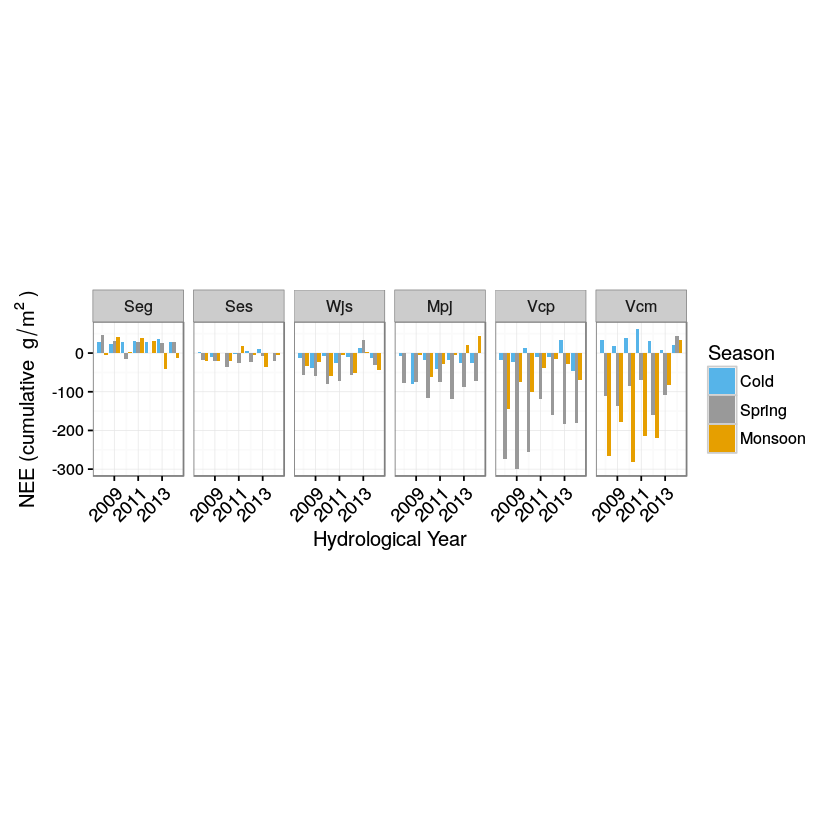

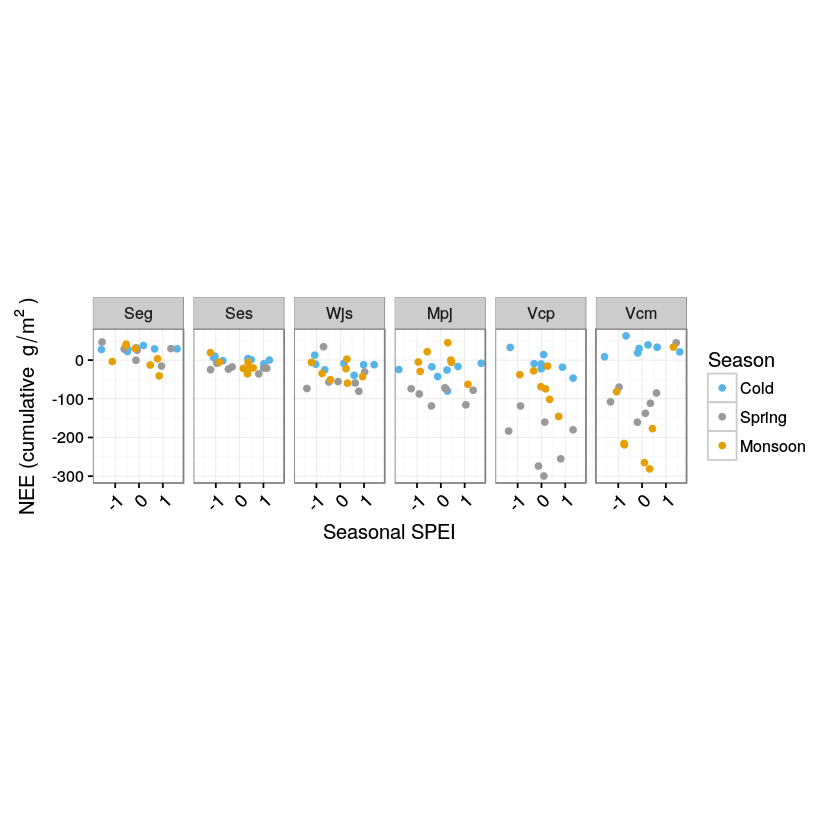

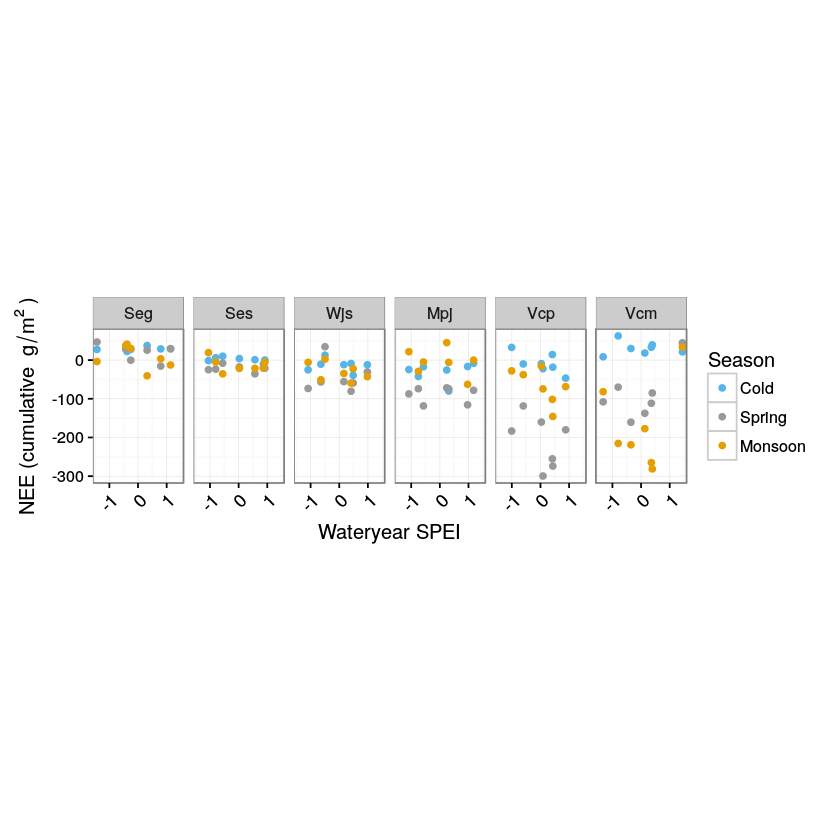

In [197]:
asp_ratio <- 1.7

FC.m <- melt(clean_rename(FC_daily), id.vars=c('season', 'year_w'))
FC.m <- ddply(FC.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(FC.m)
FC.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(FC.m)

# Merge in the annual values of SPEI
FC.m <- merge(FC.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
FC.m <- FC.m[with(FC.m, order(variable, season, year_w)),]
str(FC.m)

NEE_seas_by_yr <- ggplot(FC.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity', position='dodge') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Hydrological Year') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
NEE_seas_by_yr


NEE_seas_by_spei <- ggplot(FC.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity', position='dodge') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
NEE_seas_by_spei


NEE_seas_by_annspei <- ggplot(FC.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
NEE_seas_by_annspei

,variable,season,year_w,seas_sum
1,Seg,Cold,2008,17.97577
2,Seg,Cold,2009,13.41179
3,Seg,Cold,2010,12.80196
4,Seg,Cold,2011,19.61351
5,Seg,Cold,2012,16.0297
6,Seg,Cold,2013,20.42253


'data.frame':	126 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  18 13.4 12.8 19.6 16 ...
 $ spei_seas: num  -1.58 -0.486 0.655 -0.118 -0.469 ...
'data.frame':	126 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ seas_sum       : num  18 13.4 12.8 19.6 16 ...
 $ spei_seas      : num  -1.58 -0.486 0.655 -0.118 -0.469 ...
 $ wyear_mean_spei: num  -1.432 -0.384 0.793 -0.428 -0.253 ...


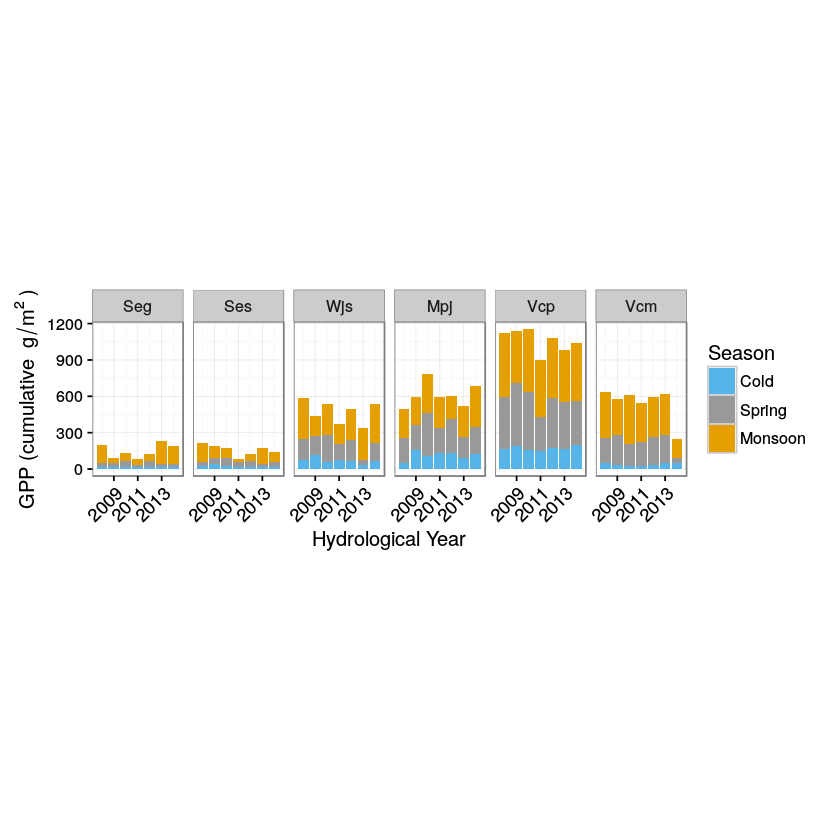

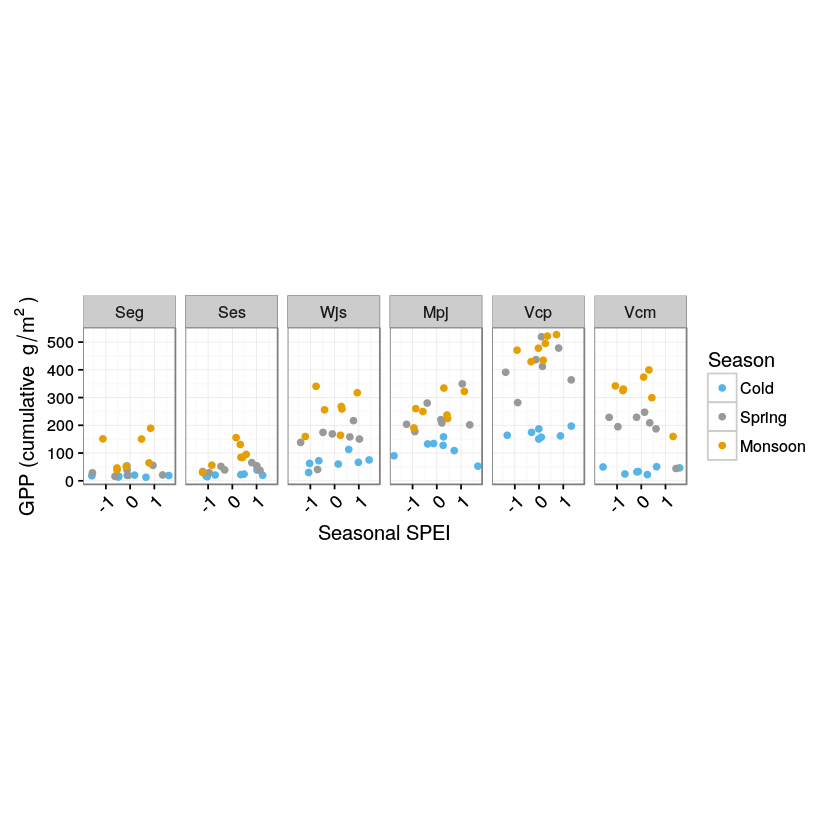

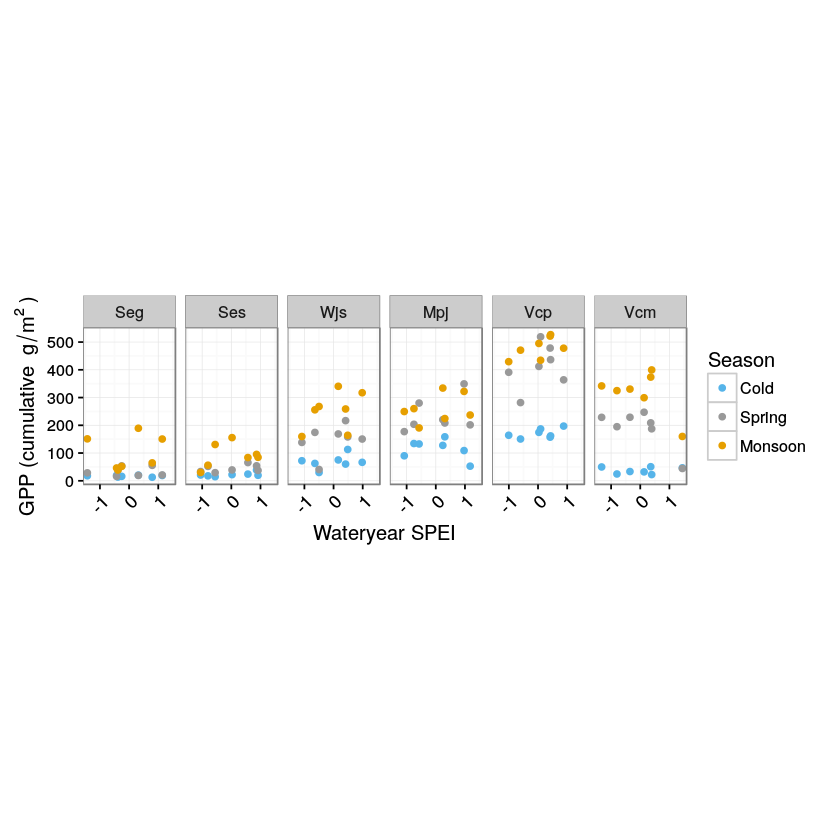

In [198]:
GPP.m <- melt(clean_rename(GPP_daily), id.vars=c('season', 'year_w'))
GPP.m <- ddply(GPP.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(GPP.m)
GPP.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(GPP.m)
# Merge in the annual values of SPEI
GPP.m <- merge(GPP.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
GPP.m <- GPP.m[with(GPP.m, order(variable, season, year_w)),]
str(GPP.m)

GPP_seas_by_yr <- ggplot(GPP.m, aes(x=year_w, y=seas_sum, fill=season)) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Hydrological Year') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_yr


GPP_seas_by_seasspei <- ggplot(GPP.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_seasspei

GPP_seas_by_annspei <- ggplot(GPP.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_annspei

In [194]:
# Plot stacked bars but ordered by annual spei
GPP.m$year_w_f <- as.factor(GPP.m$year_w)
#siteyear <- apply(GPP.m[,c('variable', 'year_w')], 1, paste, collapse=" ")
#test <- as.factor(siteyear)
#levels(test)
GPP.m$rank_spei_bysite <- ave( GPP.m$wyear_mean_spei,  as.factor(GPP.m$variable), FUN=rank)
GPP.m[20:29,]
#test3
#length(test3)
#GPP.m <- GPP.m[with(GPP.m, order(variable, season, wyear_mean_spei)),]
#GPP.m$year_w_f <- reorder(GPP.m$year_w_f, GPP.m$wyear_mean_spei)
#levels(GPP.m$year_w_f)
GPP_seas_by_annspei2 <- ggplot(order_by(year_w_f, ~wyear_mean_spei, GPP.m), aes(x=year_w_f, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + 
    #geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Year, ordered by mean SPEI') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=7)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    scale_x_discrete(limits=c('2', '5', '8', '11', '14', '17', '20')) +
    theme(aspect.ratio=asp_ratio)
GPP_seas_by_annspei2

,variable,year_w,season,seas_sum,spei_seas,wyear_mean_spei,year_w_f,rank_spei_bysite
37,Seg,2013,Monsoon,189.3446,0.8461824,0.3181369,2013,14
42,Seg,2014,Monsoon,150.5398,0.4699966,1.136646,2014,20
43,Ses,2008,Cold,22.09274,0.348536,0.02466983,2008,11
48,Ses,2009,Cold,38.80781,1.018162,0.865812,2009,17
51,Ses,2010,Cold,24.1324,0.4833938,0.5686777,2010,14
54,Ses,2011,Cold,20.79274,-0.7088149,-1.052431,2011,2
56,Ses,2012,Cold,17.79942,-1.087063,-0.8010804,2012,5
60,Ses,2013,Cold,14.73977,-1.037809,-0.555694,2013,8
62,Ses,2014,Cold,19.80012,1.251491,0.9153541,2014,20
45,Ses,2008,Spring,39.14412,-0.3165278,0.02466983,2008,11


ERROR: Error in ggplot(order_by(year_w_f, ~wyear_mean_spei, GPP.m), aes(x = year_w_f, : could not find function "order_by"


Warning message:
: Removed 126 rows containing missing values (position_stack).

ERROR: Error in matrix(value, n, p): 'data' must be of a vector type, was 'NULL'


ERROR: Error in file(con, "rb"): cannot open the connection


ERROR: Error in file(con, "rb"): cannot open the connection


ERROR: Error in file(con, "rb"): cannot open the connection


ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

,variable,season,year_w,seas_sum
1,Seg,Cold,2008,45.39975
2,Seg,Cold,2009,35.55963
3,Seg,Cold,2010,41.74366
4,Seg,Cold,2011,51.25024
5,Seg,Cold,2012,43.57342
6,Seg,Cold,2013,58.06077


'data.frame':	126 obs. of  5 variables:
 $ variable : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ season   : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ year_w   : num  2008 2009 2010 2011 2012 ...
 $ seas_sum : num  45.4 35.6 41.7 51.3 43.6 ...
 $ spei_seas: num  -1.58 -0.486 0.655 -0.118 -0.469 ...
'data.frame':	126 obs. of  6 variables:
 $ variable       : Factor w/ 6 levels "Seg","Ses","Wjs",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w         : num  2008 2009 2010 2011 2012 ...
 $ season         : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ seas_sum       : num  45.4 35.6 41.7 51.3 43.6 ...
 $ spei_seas      : num  -1.58 -0.486 0.655 -0.118 -0.469 ...
 $ wyear_mean_spei: num  -1.432 -0.384 0.793 -0.428 -0.253 ...


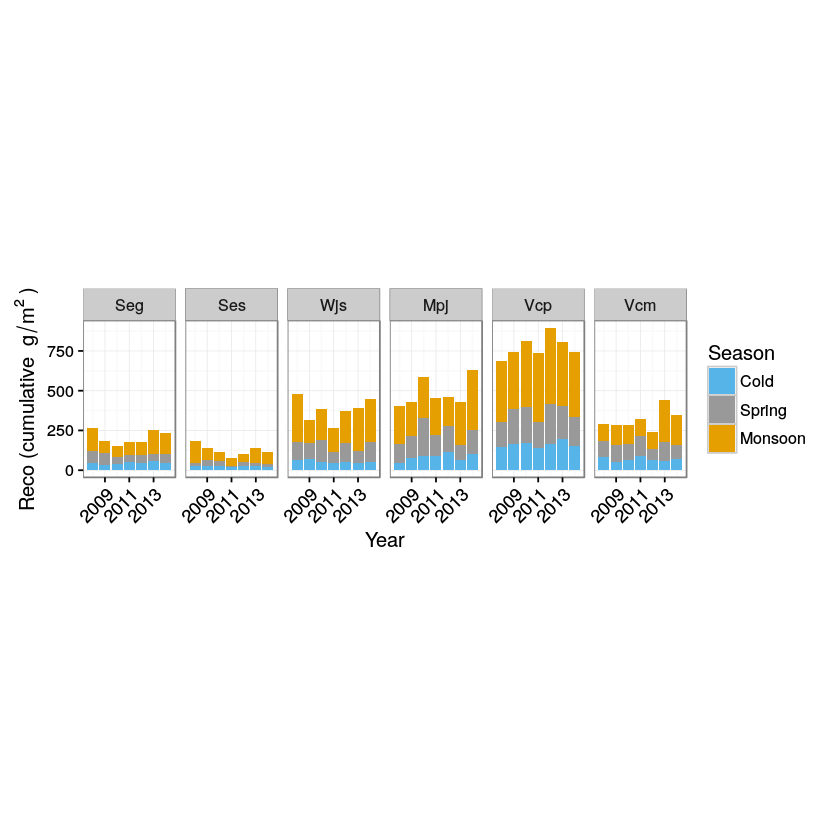

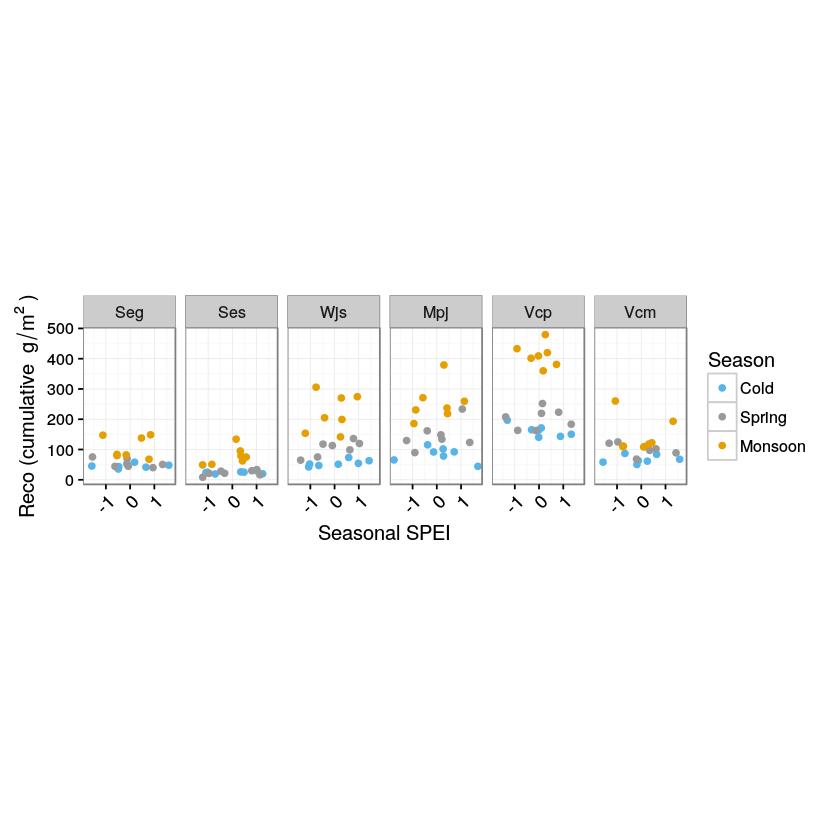

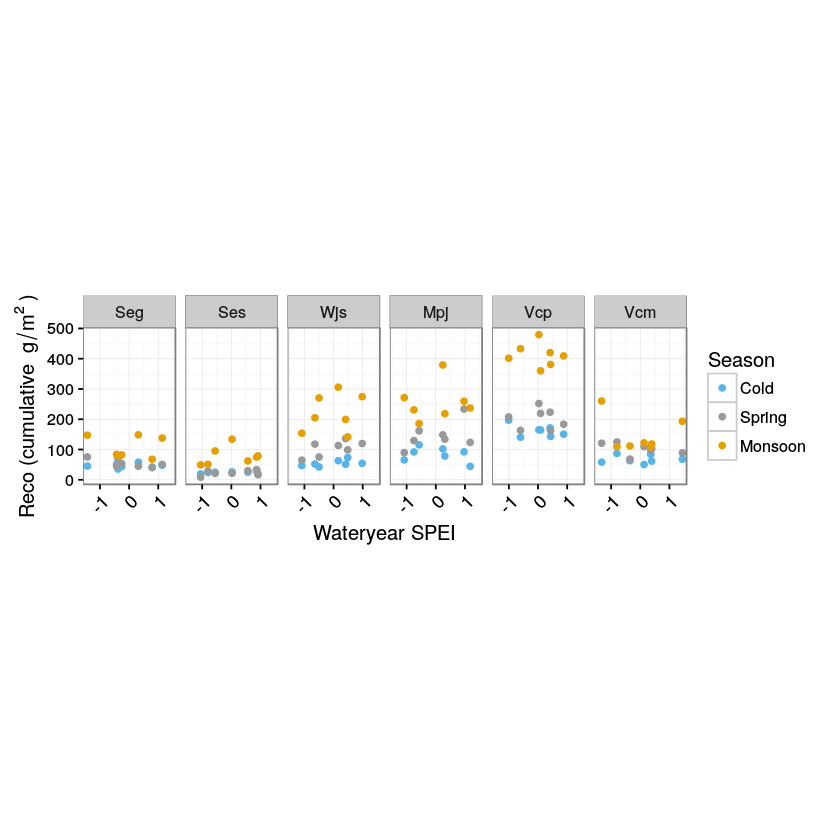

In [199]:

RE.m <- melt(clean_rename(RE_daily), id.vars=c('season', 'year_w'))
RE.m <- ddply(RE.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))
head(RE.m)
RE.m$spei_seas <- spei_seas_avg$seas_mean_spei
str(RE.m)
# Merge in the annual values of SPEI
RE.m <- merge(RE.m, spei_wyear_avg, by=c('variable', 'year_w'))
# The merge messes up the order - reorder it
RE.m <- RE.m[with(RE.m, order(variable, season, year_w)),]
str(RE.m)

RE_seas_by_yr <- ggplot(RE.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + 
    facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('Reco (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RE_seas_by_yr

RE_seas_by_spei <- ggplot(RE.m, aes(x=spei_seas, y=seas_sum, col=factor(season))) +
    #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Seasonal SPEI') + ylab(bquote('Reco (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RE_seas_by_spei

RE_seas_by_annspei <- ggplot(RE.m, aes(x=wyear_mean_spei, y=seas_sum, col=factor(season))) +
     #geom_bar(stat='identity') + 
    geom_point() +
    facet_wrap(~variable, nrow=1) + 
    xlab('Wateryear SPEI') + ylab(bquote('Reco (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=asp_ratio)
RE_seas_by_annspei